# PyCPT Version 2

This is an example of a PyCPT Version 2 seasonal climate forecasting workflow. This notebook can be adapted to suit your exact needs through modifications of the code. This notebook uses PyCPT v2 utilities to 

1. download data from the IRI Data Library (through the CPT-DL python library) 
2. Run bias-correction using the IRI Climate Predictability Tool (through its companion python library, CPT-CORE) 
3. Plot skills scores and spatial loadings
4. Produce a multi-model ensemble forecast by taking the simple average of the bias-corrected members
5. Plots skill scores, deterministic forecasts, probabilistic forecasts, and exceedance probabilities for this NextGen MME forecast. 

PyCPT Version 2 was primarily designed and implemented by Kyle Hall

#### Imports - This cell imports PyCPTv2 libraries 

In [1]:
import cptdl as dl 
import cptio as cio 
import cptcore as cc 
import cptextras as ce 

import xarray as xr 
import datetime as dt 
from pathlib import Path 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import numpy as np

#### Parameters - This cell defines the parameters of your analysis

In [2]:
MOS = 'CCA' # must be one of 'CCA', 'PCR', or "None"
predictor_names = ['SEAS5.PRCP','SPEAR.PRCP',  'CanSIPSIC3.PRCP' ]
predictand_name = 'UCSB.PRCP'

# use dl.observations.keys() to see all options for predictand 
# and dl.hindcasts.keys() to see all options for predictors
# make sure your first_year & final_year are compatible with 
# your selections for your predictors and predictands 

download_args = { 
   # 'fdate':
   #   the initialization date of the model forecasts / hindcasts
   #   this field is defined by a python datetime.datetime object
   #   for example: dt.datetime(2022, 5, 1) # YYYY, MM, DD as integers
   #   The year field is only used for forecasts, otherwise ignored
   #   The day field is only used in subseasonal forecasts, otherwise ignored
   #   The month field is an integer representing a month - ie, May=5
  'fdate': dt.datetime(2022, 5, 1),  
    
   # 'first_year':
   #   the first year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**
   #   double check that your model has hindcast data for all years in [first_year, final_year]
   #   This field is defined by a python integer representing a year, ie: 1993
  'first_year': 1993, 
    
   # 'final_year':
   #   the final year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**
   #   double check that your model has hindcast data for all years in [first_year, final_year]
   #   This field is defined by a python integer representing a year, ie: 2016
  'final_year': 2016, 
    
   # 'predictor_extent':
   #   The geographic bounding box of the climate model data you want to download
   #   This field is defined by a python dictionary with the keys "north", "south",
   #   "east", and "west", each of which maps to a python integer representing the 
   #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
   #   "south" the southernmost boundary. Example: {"north": 90, "south": 90, "east": 0, "west": 180}
  'predictor_extent': {
    'east': 80,
    'west': -20, 
    'north': 45, 
    'south': -45
  }, 
    
   # 'predictand_extent':
   #   The geographic bounding box of the observation data you want to download
   #   This field is defined by a python dictionary with the keys "north", "south",
   #   "east", and "west", each of which maps to a python integer representing the 
   #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
   #   "south" the southernmost boundary. Example: {"north": 90, "south": 90, "east": 0, "west": 180}
  'predictand_extent': {
    'east': 80,
    'west': -20, 
    'north': 45, 
    'south': -45
  }, 
    
   # 'lead_low': 
   #   the number of months from the first of the initialization month to the center of 
   #   the first month included in the target period. Always an integer + 0.5. 
   #   this field is defined by a python floating point number 
   #   for example  a lead-1 forecast would use lead_low=1.5, if you want init=may, target=Jun-..
  'lead_low': 1.5,
    
   # 'lead_high': 
   #   the number of months from the first of the initialization month to the center of 
   #   the last month included in the target period. Always an integer + 0.5. 
   #   this field is defined by a python floating point number 
   #   for example  a forecast initialized in may, whose target period ended in Aug, 
   #   would use lead_high=3.5
  'lead_high': 3.5, 
    
   # 'target': 
   #   Mmm-Mmm indicating the months included in the target period of the forecast. 
   #   this field is defined by a python string, with two three-letter month name abbreviations 
   #   whose first letters are capitalized, and all other letters are lowercase
   #   and who are separated by a dash character. 
   #   for example, if you wanted a JJA target period, you would use 'Jun-Aug'
  'target': 'Jun-Aug',
    
   # 'filetype':
   #   the filetype to be downloaded. for now, it saves a lot of headache just to set this equal
   #   to 'cptv10.tsv' which is a boutique plain-text CPT filetype based on .tsv + metadata
  'filetype': 'cptv10.tsv'
}

cca_args = { 
    'transform_predictand': None,  # transformation to apply to the predictand dataset - None, 'Empirical', 'Gamma'
    'tailoring': None,  # tailoring None, Anomaly, StdAnomaly, or SPI (SPI only available on Gamma)
    'cca_modes': (1,5), # minimum and maximum of allowed CCA modes 
    'x_eof_modes': (1,5), # minimum and maximum of allowed X Principal Componenets 
    'y_eof_modes': (1,5), # minimum and maximum of allowed Y Principal Components 
    'crossvalidation_window': 5,  # number of samples to leave out in each cross-validation step 
    'synchronous_predictors': True, # whether or not we are using 'synchronous predictors'
}

pcr_args = {
    'transform_predictand': 'Empirical',  # transformation to apply to the predictand dataset - None, 'Empirical', 'Gamma'
    'tailoring': None,  # tailoring None, Anomaly, StdAnomaly, or SPI (SPI only available on Gamma)
    'x_eof_modes': (1,5), # minimum and maximum of allowed X Principal Componenets 
    'crossvalidation_window': 5,  # number of samples to leave out in each cross-validation step 
    'synchronous_predictors': True, # whether or not we are using 'synchronous predictors'
}

nomos_args = {
    'synchronous_predictors': True, # whether or not we are using 'synchronous predictors'
}

force_download = False

#### Download Observations

In [3]:
if not Path('{}.nc'.format(predictand_name)).is_file() or force_download:
    Y = dl.download(dl.observations[predictand_name], predictand_name +'.tsv', **download_args, verbose=True, use_dlauth=False)
    Y = getattr(Y, [i for i in Y.data_vars][0])
    Y.to_netcdf('{}.nc'.format(predictand_name))
else:
    Y = xr.open_dataset('{}.nc'.format(predictand_name))
    Y = getattr(Y, [i for i in Y.data_vars][0])

URL: https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/92/mul/T/(1%20Jan%201993)/(31%20Dec%202016)/RANGE/T/%28Jun-Aug%201993-2016%29/seasonalAverage/Y/%28-45%29/%2845%29/RANGEEDGES/X/%28-20%29/%2880%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv

DOWNLOADING: [*************************] (48923 KB) 0:00:29.619188


#### Download Hindcast Data

In [4]:
# download training data 
hindcast_data = []
for model in predictor_names: 
    if not Path(model + '.nc').is_file() or force_download:
        X = dl.download(dl.hindcasts[model], model+'.tsv', **download_args, verbose=True, use_dlauth=False)
        X = getattr(X, [i for i in X.data_vars][0])
        X.name = Y.name
        X.to_netcdf('{}.nc'.format(model))
    else:
        X = xr.open_dataset(model + '.nc')
        X = getattr(X, [i for i in X.data_vars][0])
        X.name = Y.name
    hindcast_data.append(X)

URL: https://iridl.ldeo.columbia.edu/SOURCES/.EU/.Copernicus/.CDS/.C3S/.ECMWF/.SEAS5/.hindcast/.prcp/S/%280000%201%20May%201993-2016%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-45/45/RANGEEDGES/X/-20/80/RANGEEDGES/%5BM%5D/average/c%3A/1000/(mm%20m-1)/%3Ac/mul/c%3A/86400/(s%20day-1)/%3Ac/mul/c%3A/92//units/(days)/def/%3Ac/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (3145 KB) 0:00:05.380710
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.HINDCAST/.MONTHLY/.prec/%5BM%5D/average/S/first/(1%20Nov%202020)/RANGEEDGES/SOURCES/.Models/.NMME/.GFDL-SPEAR/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/appendstream/S/%280000%201%20May%201993-2016%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-45/45/RANGEEDGES/X/-20/80/RANGEEDGES/92/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (3145 KB) 0:00:16.327052
URL: https://iridl.ldeo.columbia.edu/

#### Download Forecast Data

In [5]:
# download forecast data 
forecast_data = []
for model in predictor_names: 
    if not Path(model + '_f.nc').is_file() or force_download:
        F = dl.download(dl.forecasts[model], model+'_f.tsv', **download_args, verbose=True, use_dlauth=False)
        F = getattr(F, [i for i in F.data_vars][0])
        F.name = Y.name
        F.to_netcdf(model + '_f.nc')
    else:
        F = xr.open_dataset(model + '_f.nc')
        F = getattr(F, [i for i in F.data_vars][0])
        F.name = Y.name
    forecast_data.append(F)

URL: https://iridl.ldeo.columbia.edu/SOURCES/.EU/.Copernicus/.CDS/.C3S/.ECMWF/.SEAS5/.forecast/.prcp/S/%280000%201%20May%202022%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-45/45/RANGEEDGES/X/-20/80/RANGEEDGES/%5BM%5D/average/c%3A/1000/(mm%20m-1)/%3Ac/mul/c%3A/86400/(s%20day-1)/%3Ac/mul/c%3A/92//units/(days)/def/%3Ac/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (134 KB) 0:00:00.793844
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/S/%280000%201%20May%202022%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-45/45/RANGEEDGES/X/-20/80/RANGEEDGES/92/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (131 KB) 0:00:01.554501
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanSIPS-IC3/.FORECAST/.MONTHLY/.prec/S/%280000%201%20May%202022%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids

#### Perform Analysis 

In [6]:
hcsts, fcsts, skill, pxs, pys = [], [], [], [], []

for i, model_hcst in enumerate(hindcast_data):
    
    if str(MOS).upper() == 'CCA':
        cca_h, cca_rtf, cca_s, cca_px, cca_py = cc.canonical_correlation_analysis(model_hcst, Y, F=forecast_data[i], **cca_args)
        cca_h, cca_f, cca_s, cca_px, cca_py = cc.canonical_correlation_analysis(model_hcst, Y, F=ce.redate(model_hcst), **cca_args)
        cca_h = xr.merge([cca_h, ce.redate(cca_f.probabilistic, yeardelta=-100), ce.redate(cca_f.prediction_error_variance, yeardelta=-100)])
        
        cca_pfv = cc.probabilistic_forecast_verification(cca_h.probabilistic, Y, **nomos_args)
        cca_s = xr.merge([cca_s, cca_pfv])

        hcsts.append(cca_h)
        fcsts.append(cca_rtf)
        skill.append(cca_s.where(cca_s > -999, other=np.nan))
        pxs.append(cca_px)
        pys.append(cca_py)
    elif str(MOS).upper() == 'PCR':
        pcr_h, pcr_rtf, pcr_s, pcr_px = cc.principal_components_regression(model_hcst, Y, F=forecast_data[i], **pcr_args)
        pcr_h, pcr_f, pcr_s, pcr_px = cc.principal_components_regression(model_hcst, Y, F=ce.redate(model_hcst), **pcr_args)
        pcr_h = xr.merge([pcr_h, ce.redate(pcr_f.probabilistic, yeardelta=-100), ce.redate(pcr_f.prediction_error_variance, yeardelta=-100)])
        pcr_pfv = cc.probabilistic_forecast_verification(pcr_h.probabilistic, Y, **nomos_args)
        pcr_s = xr.merge([pcr_s, pcr_pfv])
        hcsts.append(pcr_h)
        fcsts.append(pcr_rtf)
        skill.append(pcr_s.where(pcr_s > -999, other=np.nan))
        pxs.append(pcr_px)
    else:
        nomos_skill = cc.deterministic_skill(model_hcst, Y, **nomos_args)
        skill.append(nomos_skill.where(nomos_skill > -999, other=np.nan))
        
    # choose what data to export here (any of the above results data arrays can be saved to netcdf)
    #cca_h.to_netcdf(predictor_names[i] + '_crossvalidated_cca_hindcasts.nc')
    #pcr_h.to_netcdf(predictor_names[i] + '_crossvalidated_pcr_hindcasts.nc')

#### Plot skill 

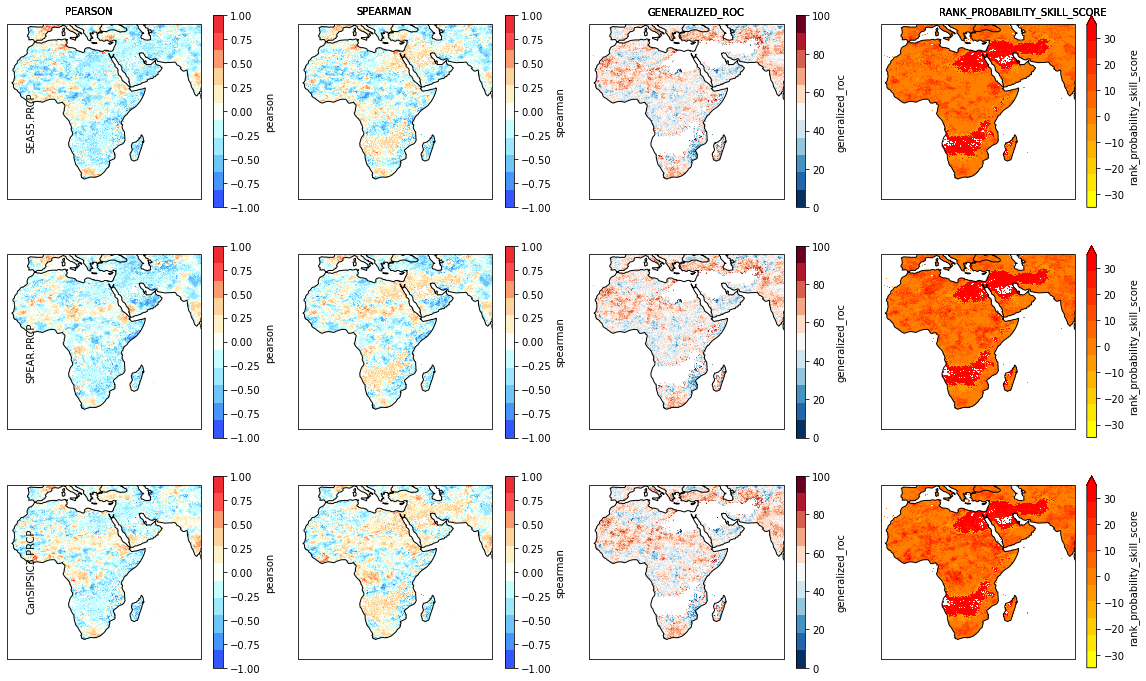

In [7]:
skill_metrics = ['pearson', 'spearman', 'generalized_roc', 'rank_probability_skill_score']
cmaps = [plt.get_cmap('cpt.correlation', 11), plt.get_cmap('cpt.correlation', 11), plt.get_cmap('RdBu_r', 11), plt.get_cmap('autumn_r', 11) ]
limits = [(-1, 1), (-1, 1), (0, 100), (-35, 35)]
missing_value_flag = -999

fig, ax = plt.subplots(nrows=len(predictor_names), ncols=len(skill_metrics), subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(5*len(skill_metrics), 4*len(predictor_names)))
if len(predictor_names) == 1: 
    ax = [ax]

for i, model in enumerate(predictor_names):
    ax[i][0].text(-10, -20, model, rotation='vertical')
    for j, skill_metric in enumerate(skill_metrics):
        ax[0][j].text(10, 50, skill_metric.upper())
        getattr(skill[i], skill_metric).where(getattr(skill[i], skill_metric) > missing_value_flag).plot(ax=ax[i][j], cmap=cmaps[j], vmin=limits[j][0], vmax=limits[j][1])
        ax[i][j].coastlines()
    

#### Plot CCA Modes

SEAS5.PRCP - MODE 1


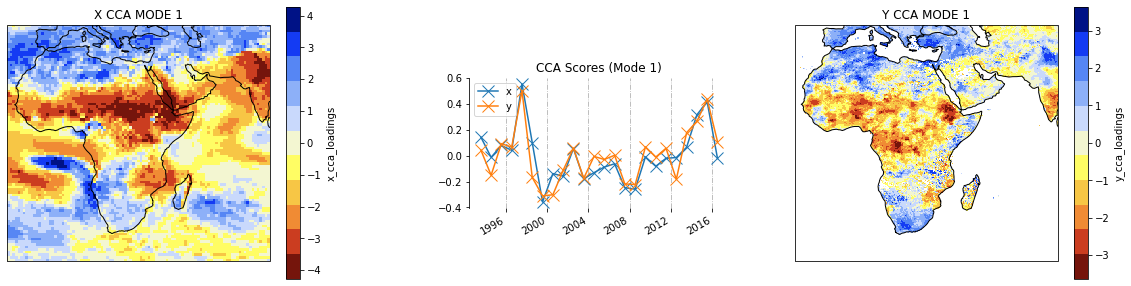

SEAS5.PRCP - MODE 2


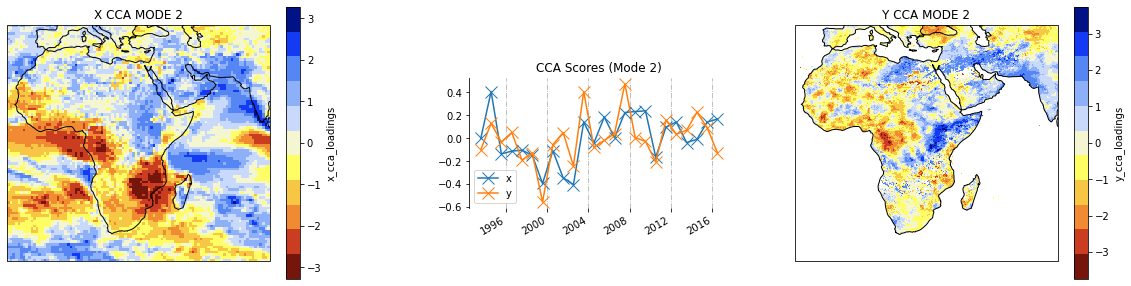

SEAS5.PRCP - MODE 3


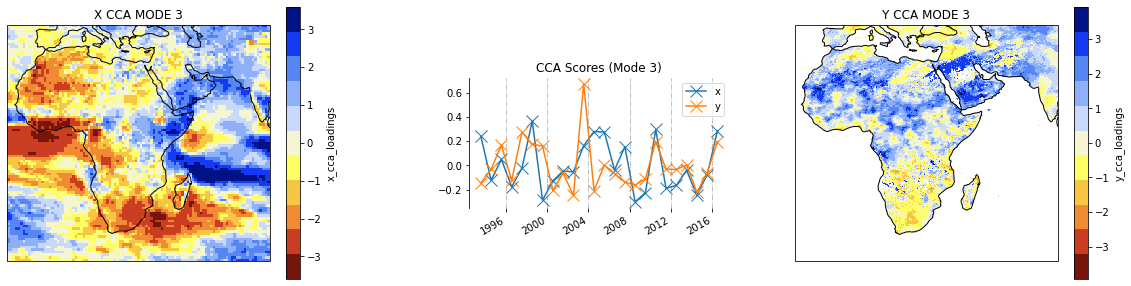

SEAS5.PRCP - MODE 4


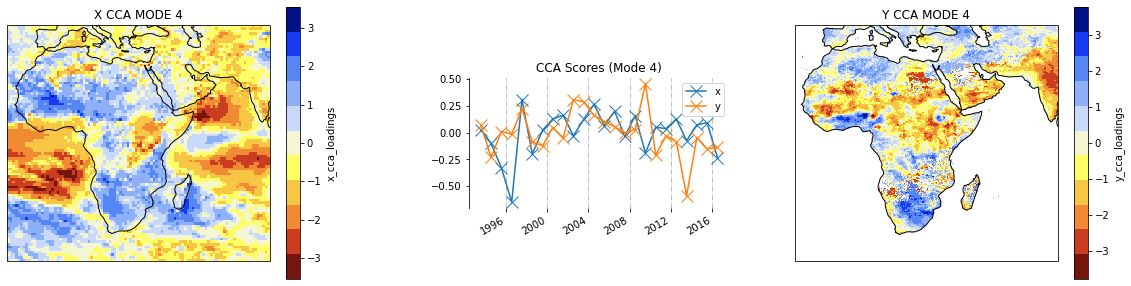

SEAS5.PRCP - MODE 5


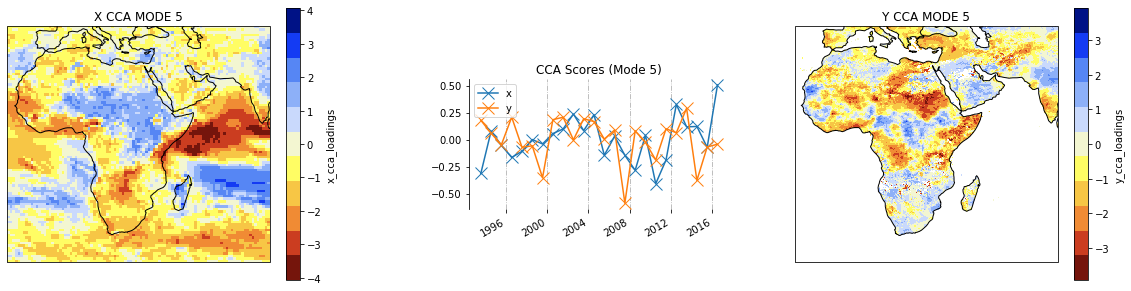

SPEAR.PRCP - MODE 1


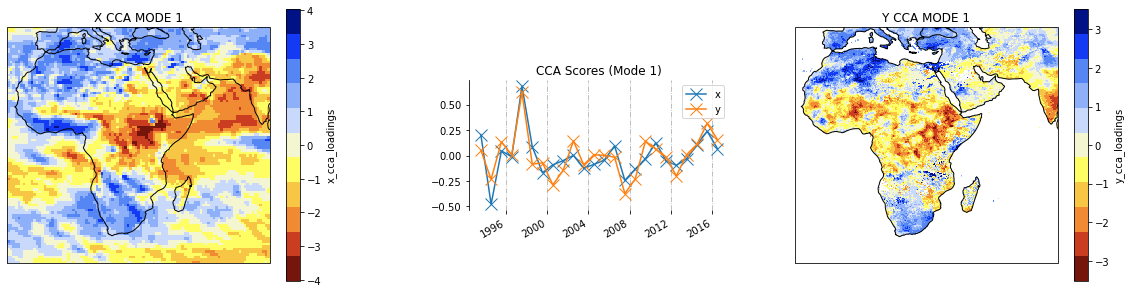

SPEAR.PRCP - MODE 2


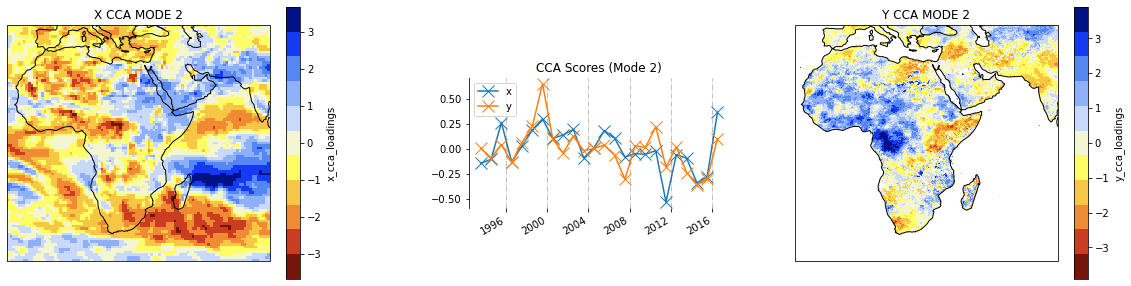

SPEAR.PRCP - MODE 3


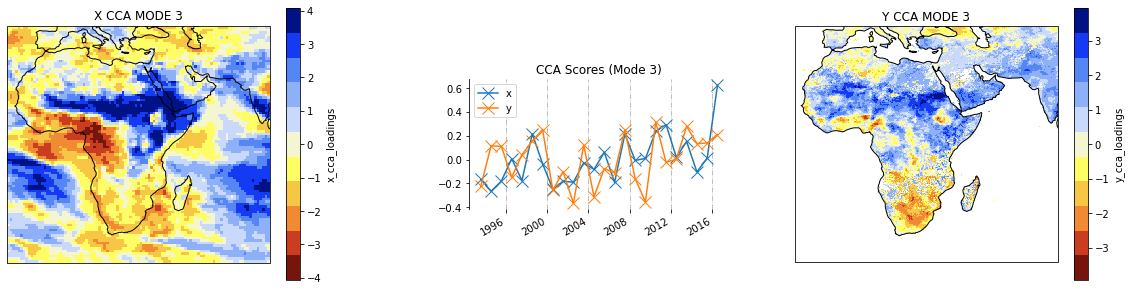

SPEAR.PRCP - MODE 4


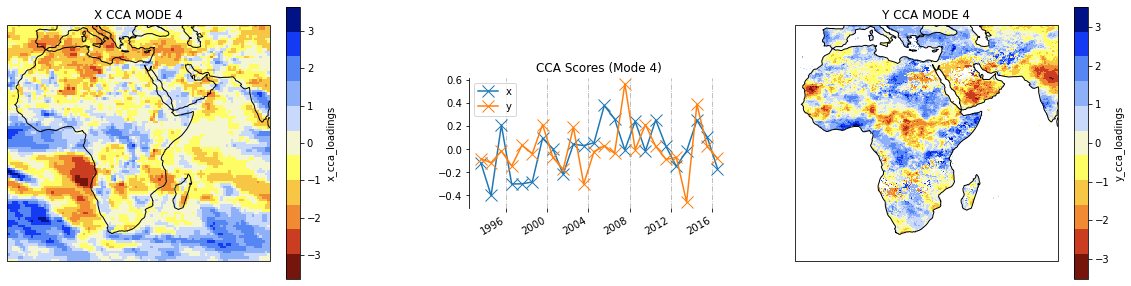

SPEAR.PRCP - MODE 5


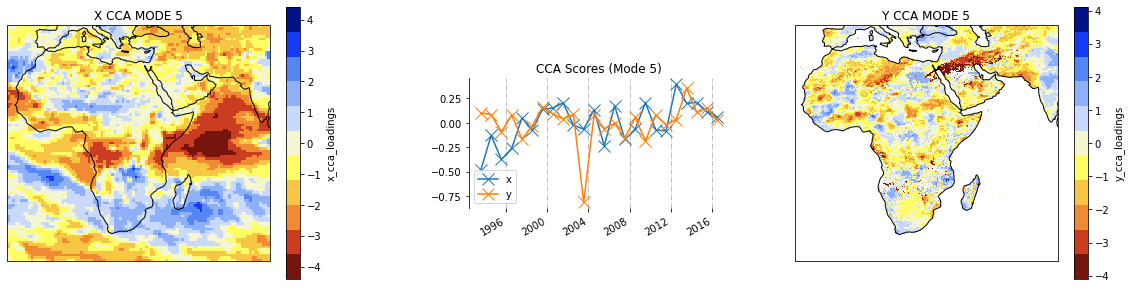

CANSIPSIC3.PRCP - MODE 1


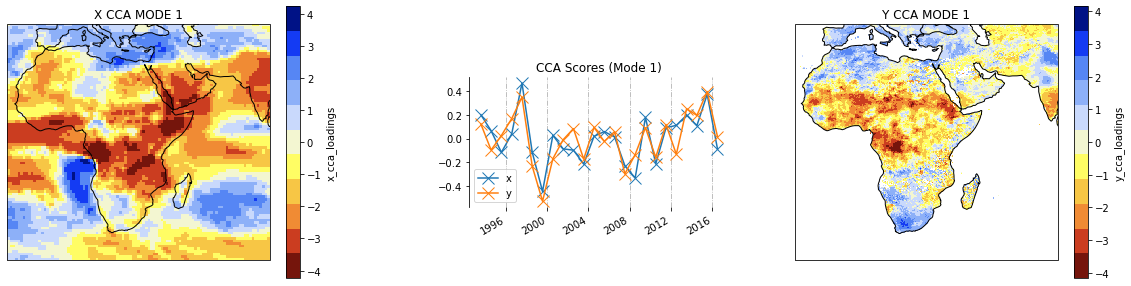

CANSIPSIC3.PRCP - MODE 2


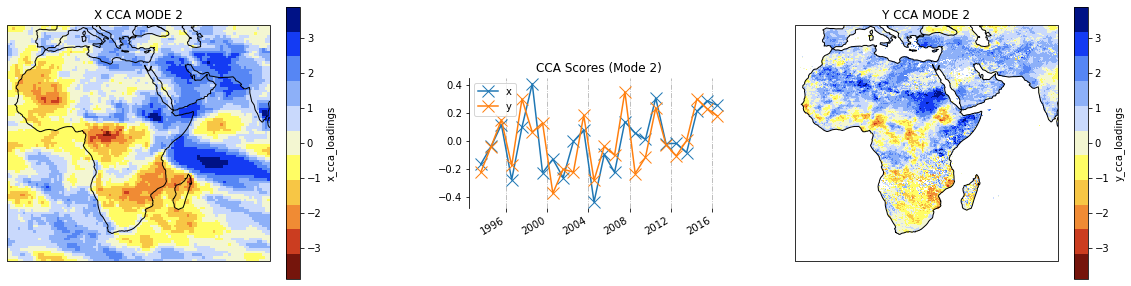

CANSIPSIC3.PRCP - MODE 3


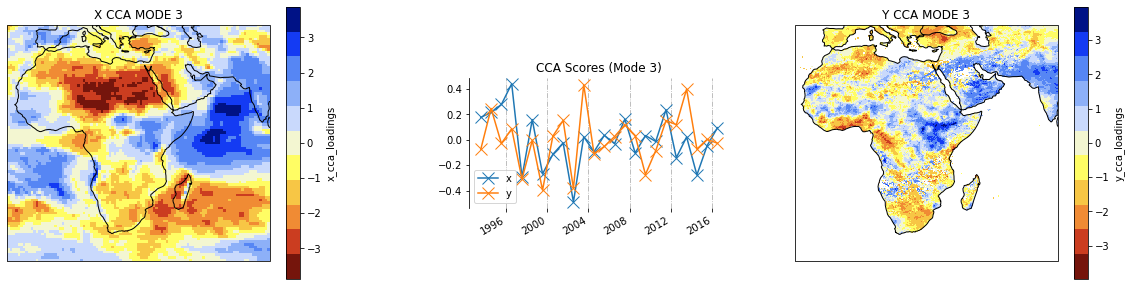

CANSIPSIC3.PRCP - MODE 4


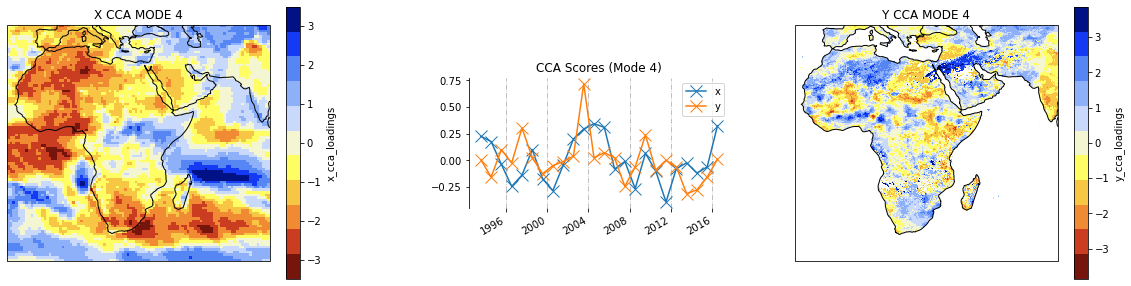

CANSIPSIC3.PRCP - MODE 5


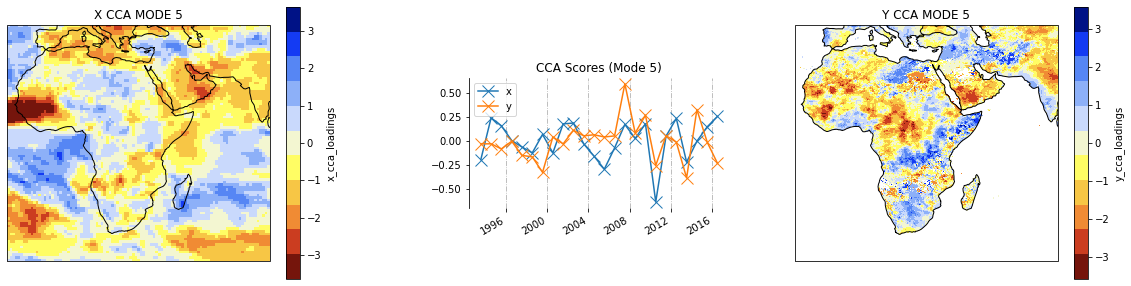

In [8]:
nmodes = 5
cmap= plt.get_cmap('cpt.loadings', 11)
vmin=-10
vmax = 10
missing_value_flag = -999

import matplotlib.gridspec as gridspec
if MOS == 'CCA':
    for i, model in enumerate(predictor_names):
        for mode in range(nmodes):
            print(model.upper() + ' - MODE {}'.format(mode+1))
            fig = plt.figure(figsize=(20,5))
            gs0 = gridspec.GridSpec(1, 3, figure=fig)
            gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])
            gs01 = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0[1])
            gs02 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[2])
            ts = xr.concat([pxs[i].x_cca_scores.isel(Mode=mode), pys[i].y_cca_scores.isel(Mode=mode)], 'M').assign_coords({'M': ['x', 'y']})
            
            map1_ax = fig.add_subplot(gs00[:,:], projection = ccrs.PlateCarree())
            ts_ax = fig.add_subplot( gs01[1:3,1:])
            map2_ax = fig.add_subplot(gs02[:,:], projection = ccrs.PlateCarree())
            
            pxs[i].x_cca_loadings.isel(Mode=mode).where(pxs[i].x_cca_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map1_ax, cmap=cmap)
            pys[i].y_cca_loadings.isel(Mode=mode).where(pys[i].y_cca_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map2_ax, cmap=cmap)

            primitive = ts.plot.line(marker='x', ax=ts_ax, markersize=12, hue='M', add_legend=False)
            ts_ax.grid(axis = 'x', linestyle = '-.')
            ts_ax.legend(handles=primitive, labels = list(ts.coords['M'].values), loc='best')
            ts_ax.spines['top'].set_visible(False)
            ts_ax.spines['right'].set_visible(False)
            ts_ax.spines['bottom'].set_visible(False)
            ts_ax.set_title('CCA Scores (Mode {})'.format(mode+1))
            ts_ax.set_ylabel(None)
            ts_ax.set_xlabel(None)
            
            map1_ax.set_title('X CCA MODE {}'.format(mode+1))
            map2_ax.set_title('Y CCA MODE {}'.format(mode+1))
            
            map1_ax.coastlines()
            map2_ax.coastlines()
            plt.show()
else:
    print('You will need to set MOS=CCA in order to see CCA Modes')
        


SEAS5.PRCP - MODE 1


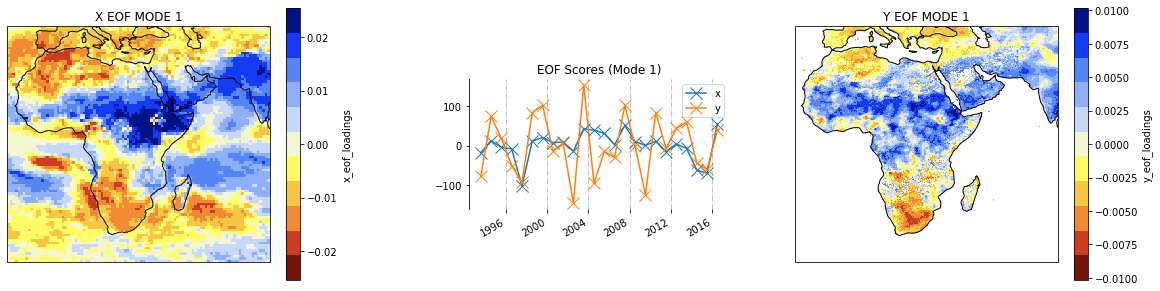

SEAS5.PRCP - MODE 2


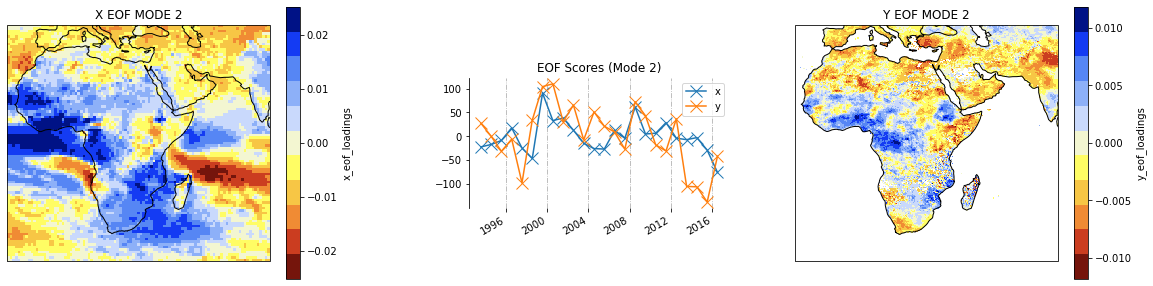

SEAS5.PRCP - MODE 3


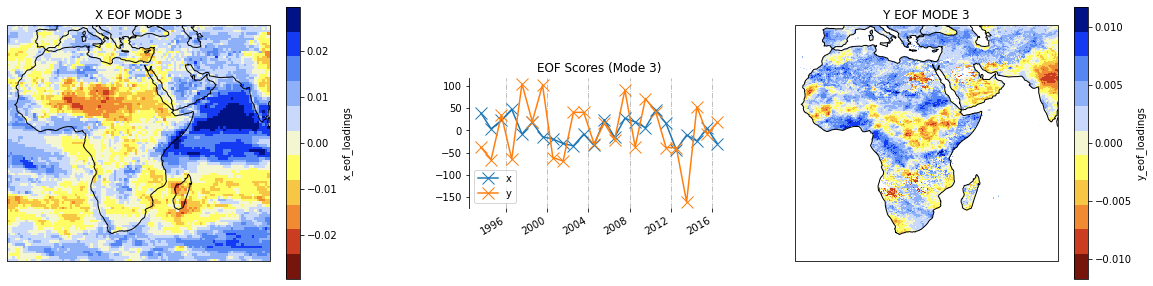

SEAS5.PRCP - MODE 4


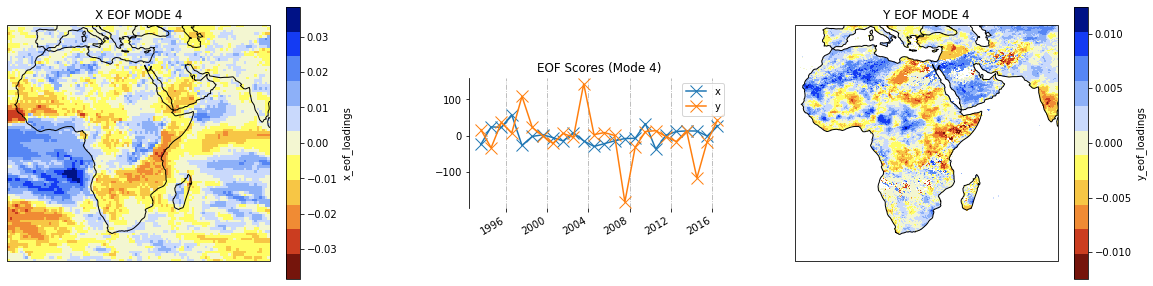

SEAS5.PRCP - MODE 5


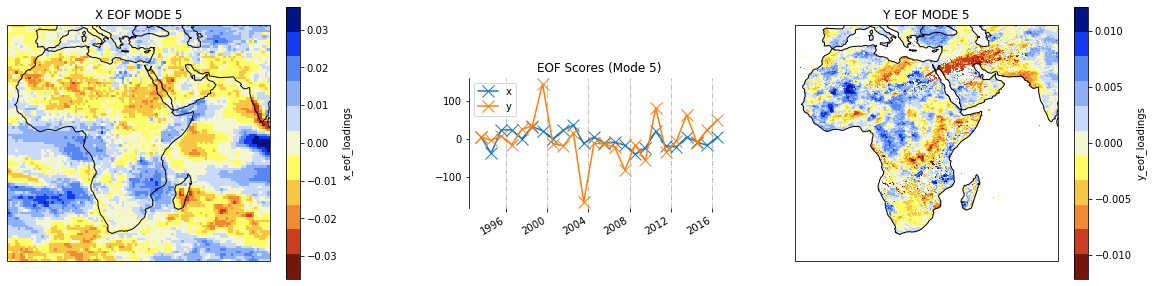

SPEAR.PRCP - MODE 1


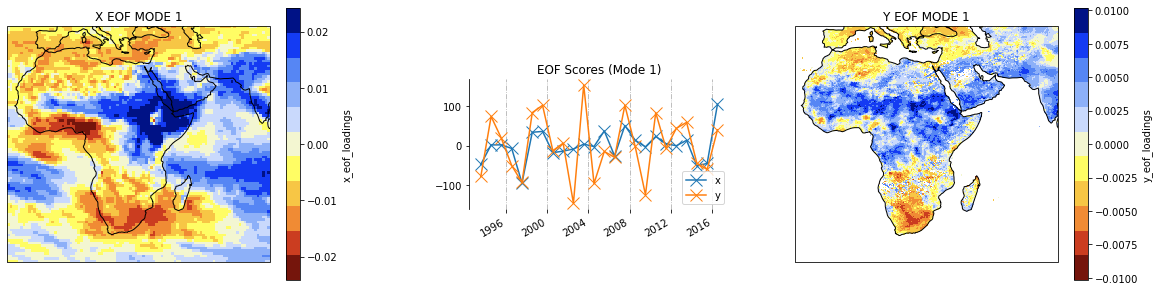

SPEAR.PRCP - MODE 2


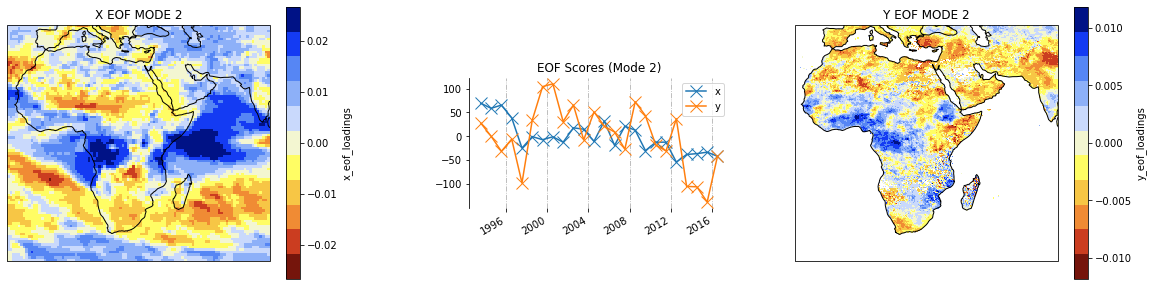

SPEAR.PRCP - MODE 3


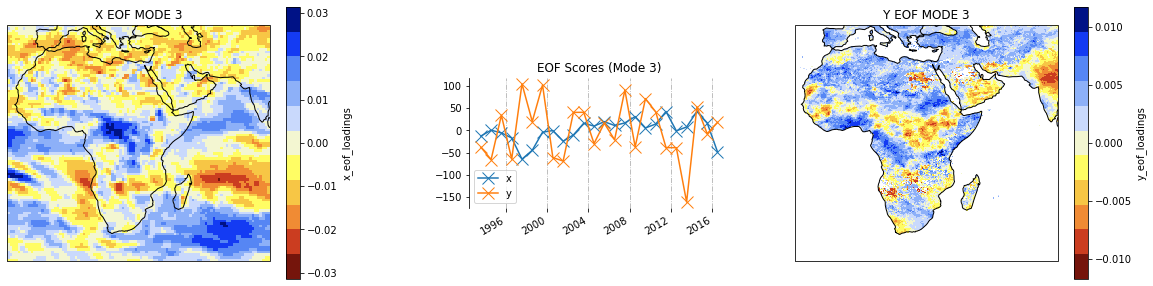

SPEAR.PRCP - MODE 4


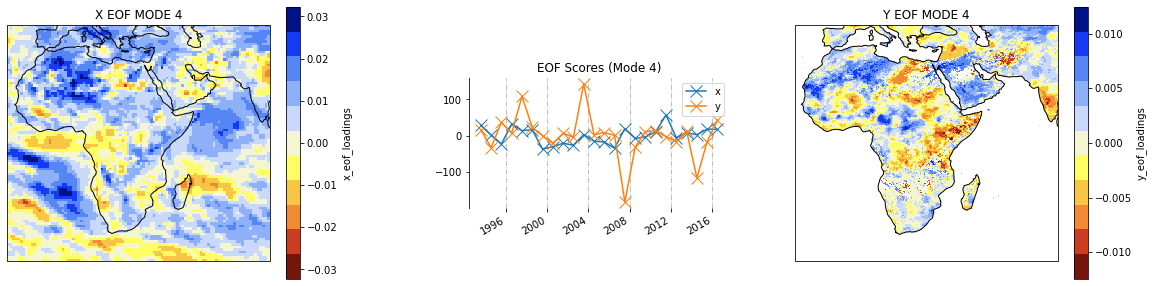

SPEAR.PRCP - MODE 5


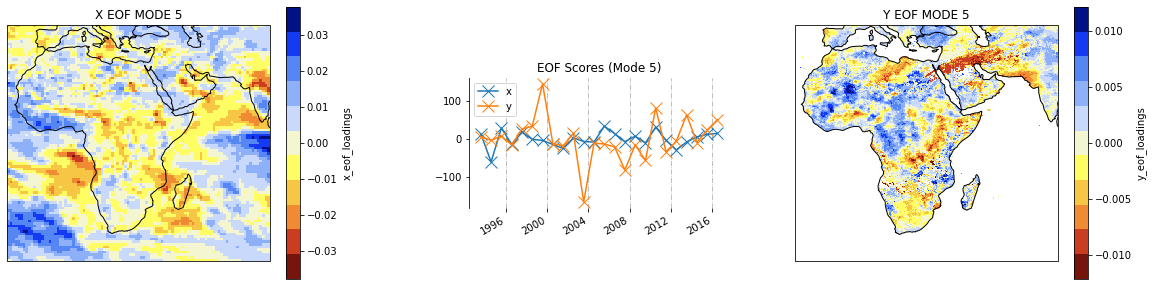

CANSIPSIC3.PRCP - MODE 1


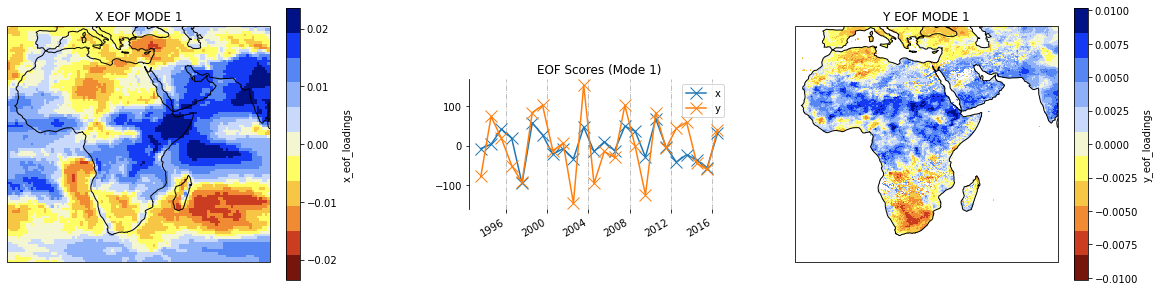

CANSIPSIC3.PRCP - MODE 2


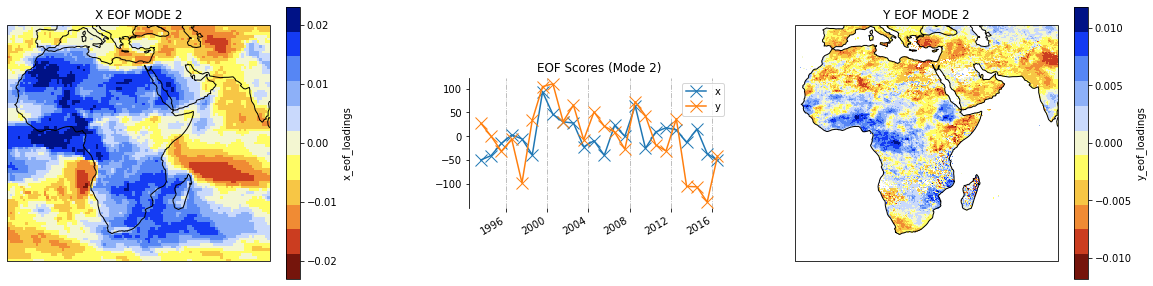

CANSIPSIC3.PRCP - MODE 3


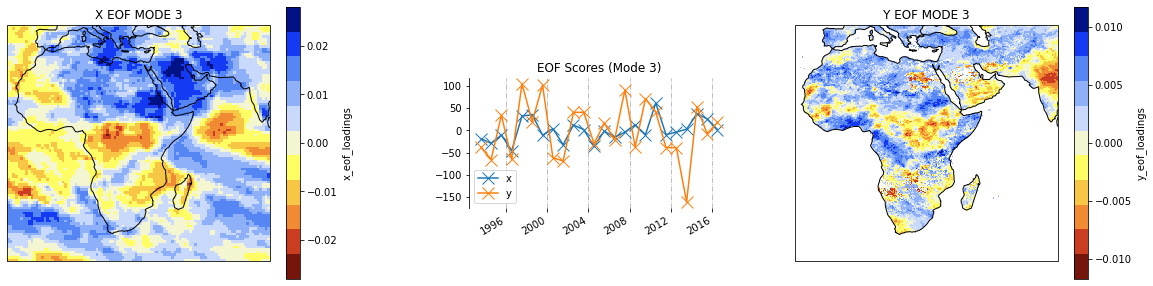

CANSIPSIC3.PRCP - MODE 4


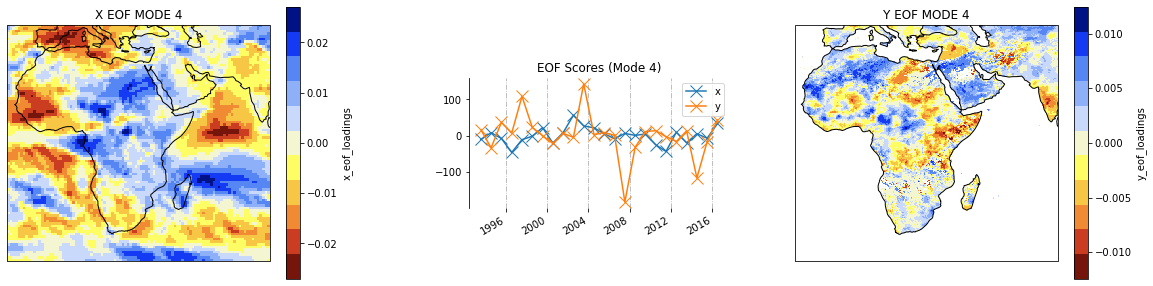

CANSIPSIC3.PRCP - MODE 5


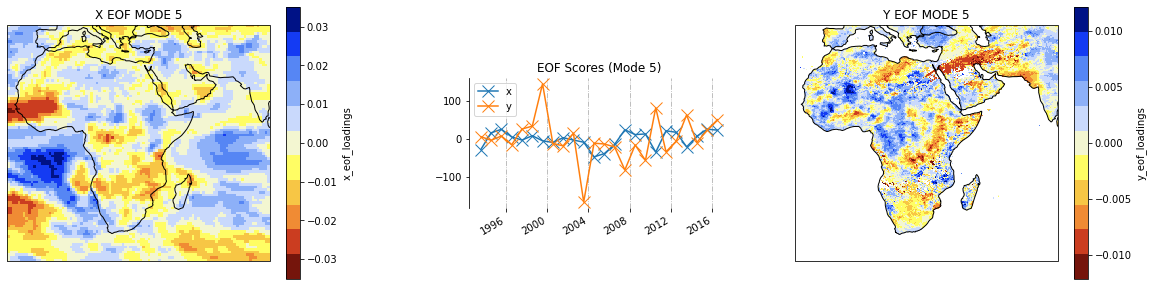

In [9]:
nmodes = 5
cmap= plt.get_cmap('cpt.loadings', 11)
vmin=-10
vmax = 10

import matplotlib.gridspec as gridspec
if MOS == 'CCA':
    for i, model in enumerate(predictor_names):
        for mode in range(nmodes):
            print(model.upper() + ' - MODE {}'.format(mode+1))
            fig = plt.figure(figsize=(20,5))
            gs0 = gridspec.GridSpec(1, 3, figure=fig)
            gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])
            gs01 = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0[1])
            gs02 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[2])
            ts = xr.concat([pxs[i].x_eof_scores.isel(Mode=mode), pys[i].y_eof_scores.isel(Mode=mode)], 'M').assign_coords({'M': ['x', 'y']})
            
            map1_ax = fig.add_subplot(gs00[:,:], projection = ccrs.PlateCarree())
            ts_ax = fig.add_subplot( gs01[1:3,1:])
            map2_ax = fig.add_subplot(gs02[:,:], projection = ccrs.PlateCarree())
            
            pxs[i].x_eof_loadings.isel(Mode=mode).where(pxs[i].x_eof_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map1_ax, cmap=cmap)
            pys[i].y_eof_loadings.isel(Mode=mode).where(pys[i].y_eof_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map2_ax, cmap=cmap)

            primitive = ts.plot.line(marker='x', ax=ts_ax, markersize=12, hue='M', add_legend=False)
            ts_ax.grid(axis = 'x', linestyle = '-.')
            ts_ax.legend(handles=primitive, labels = list(ts.coords['M'].values), loc='best')
            ts_ax.spines['top'].set_visible(False)
            ts_ax.spines['right'].set_visible(False)
            ts_ax.spines['bottom'].set_visible(False)
            ts_ax.set_title('EOF Scores (Mode {})'.format(mode+1))
            ts_ax.set_ylabel(None)
            ts_ax.set_xlabel(None)
            
            map1_ax.set_title('X EOF MODE {}'.format(mode+1))
            map2_ax.set_title('Y EOF MODE {}'.format(mode+1))
            
            map1_ax.coastlines()
            map2_ax.coastlines()
            plt.show()
elif MOS == 'PCR':
    for i, model in enumerate(predictor_names):
        for mode in range(nmodes):
            print(model.upper() + ' - MODE {}'.format(mode+1))
            fig = plt.figure(figsize=(20,5))
            gs0 = gridspec.GridSpec(1, 3, figure=fig)
            gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])
            gs01 = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0[1])
            gs02 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[2])
            ts = xr.concat([pxs[i].x_eof_scores.isel(Mode=mode)], 'M').assign_coords({'M': ['x']})
            
            map1_ax = fig.add_subplot(gs00[:,:], projection = ccrs.PlateCarree())
            ts_ax = fig.add_subplot( gs01[1:3,1:])
            map2_ax = fig.add_subplot(gs02[:,:], projection = ccrs.PlateCarree())
            
            pxs[i].x_eof_loadings.isel(Mode=mode).where(pxs[i].x_eof_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map1_ax, cmap=cmap)            #pys[i].y_eof_loadings.isel(Mode=mode).plot(ax=map2_ax, cmap=cmap)

            primitive = ts.plot.line(marker='x', ax=ts_ax, markersize=12, hue='M', add_legend=False)
            ts_ax.grid(axis = 'x', linestyle = '-.')
            ts_ax.legend(handles=primitive, labels = list(ts.coords['M'].values), loc='best')
            ts_ax.spines['top'].set_visible(False)
            ts_ax.spines['right'].set_visible(False)
            ts_ax.spines['bottom'].set_visible(False)
            ts_ax.set_title('EOF Scores (Mode {})'.format(mode+1))
            ts_ax.set_ylabel(None)
            ts_ax.set_xlabel(None)
            
            map1_ax.set_title('X EOF MODE {}'.format(mode+1))
            #map2_ax.set_title('Y EOF MODE {}'.format(mode+1))
            
            map1_ax.coastlines()
            #map2_ax.coastlines()
            plt.show()
else:
    print('You will need to set MOS=CCA in order to see CCA Modes')
        


#### Plot Forecasts

SEAS5.PRCP


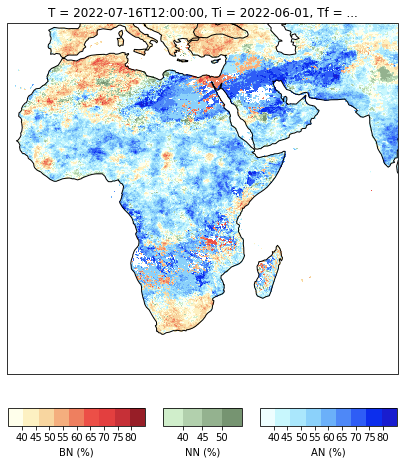

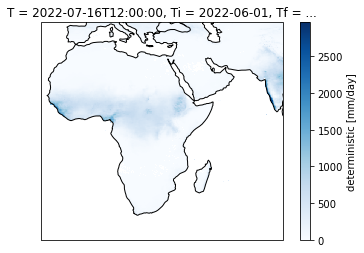

SPEAR.PRCP


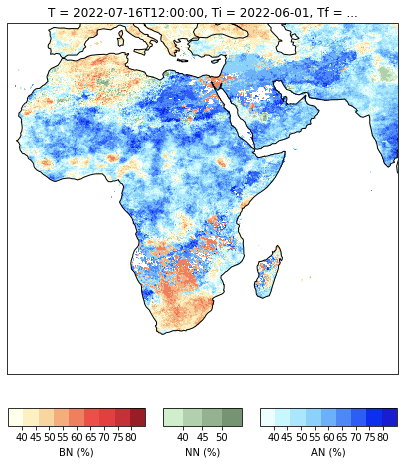

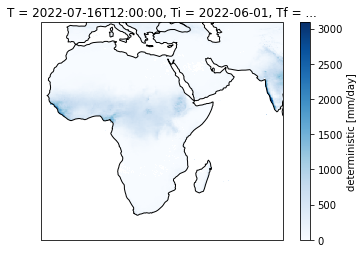

CANSIPSIC3.PRCP


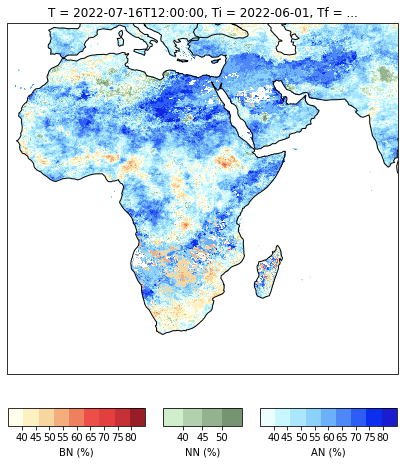

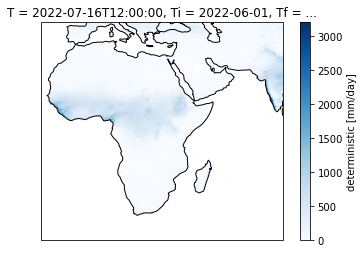

In [10]:
import xcast as xc 
missing_value_flag = -999
prob_missing_value_flag = -1
for i in range(len(fcsts)):
    print(predictor_names[i].upper())
    ce.view_probabilistic(fcsts[i].probabilistic.where(fcsts[i].probabilistic > prob_missing_value_flag).rename({'C':'M'}).isel(T=-1) / 100)
    plt.show()
    art = fcsts[i].deterministic.where(fcsts[i].deterministic > missing_value_flag).isel(T=-1).plot(subplot_kws={'projection': ccrs.PlateCarree()}, cmap='Blues', vmin=0)
    art.axes.coastlines()
    plt.show()

# Multi-Model Ensemble

In [11]:
ensemble = ['SEAS5.PRCP','SPEAR.PRCP',  'CanSIPSIC3.PRCP' ]
### Do not modify below

det_fcst = []
det_hcst = []
pr_fcst = []
pr_hcst = []
pev_fcst = []
pev_hcst = []
for model in ensemble:
    assert model in predictor_names, "all members of the nextgen ensemble must be in predictor_names - {} is not".format(model)
    ndx = predictor_names.index(model)
    
    det_fcst.append(fcsts[ndx].deterministic)
    det_hcst.append(hcsts[ndx].deterministic)
    pr_fcst.append(fcsts[ndx].probabilistic)
    pr_hcst.append(hcsts[ndx].probabilistic)
    pev_fcst.append(fcsts[ndx].prediction_error_variance)
    pev_hcst.append(hcsts[ndx].prediction_error_variance)

det_fcst = xr.concat(det_fcst, 'model').mean('model')
det_hcst = xr.concat(det_hcst, 'model').mean('model')
pr_fcst = xr.concat(pr_fcst, 'model').mean('model')
pr_hcst = xr.concat(pr_hcst, 'model').mean('model')
pev_fcst = xr.concat(pev_fcst, 'model').mean('model')
pev_hcst = xr.concat(pev_hcst, 'model').mean('model')

det_hcst.attrs['missing'] = hcsts[0].attrs['missing']
det_hcst.attrs['units'] = hcsts[0].attrs['units']

pr_hcst.attrs['missing'] = hcsts[0].attrs['missing']
pr_hcst.attrs['units'] = hcsts[0].attrs['units']


nextgen_skill_deterministic = cc.deterministic_skill(det_hcst, Y, **nomos_args)
nextgen_skill_probabilistic = cc.probabilistic_forecast_verification(pr_hcst, Y, **nomos_args)
nextgen_skill = xr.merge([nextgen_skill_deterministic, nextgen_skill_probabilistic])

#### NextGen Forecast Skill

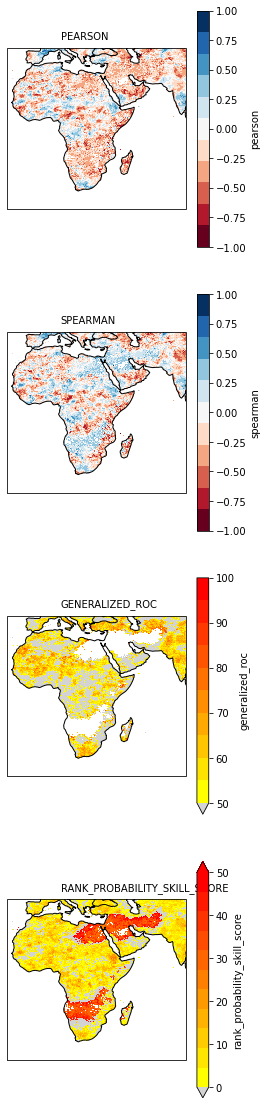

In [12]:
skill_metrics = ['pearson', 'spearman', 'generalized_roc', 'rank_probability_skill_score']
cmaps = [plt.get_cmap('RdBu', 11), plt.get_cmap('RdBu', 11), plt.get_cmap('autumn_r', 10), plt.get_cmap('autumn_r', 11) ]
limits = [(-1, 1), (-1, 1), (50, 100), (0, 50)]
cmaps[2].set_under('lightgray')
cmaps[3].set_under('lightgray')


## Do not modify below
fig, ax = plt.subplots(nrows=len(skill_metrics), ncols=1, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(4, 5*len(skill_metrics)))
for j, skill_metric in enumerate(skill_metrics):
    ax[j].text(10, 50, skill_metric.upper())
    getattr(nextgen_skill, skill_metric).where(getattr(nextgen_skill, skill_metric) > missing_value_flag).plot(ax=ax[j], cmap=cmaps[j], vmin=limits[j][0], vmax=limits[j][1])
    ax[j].coastlines()

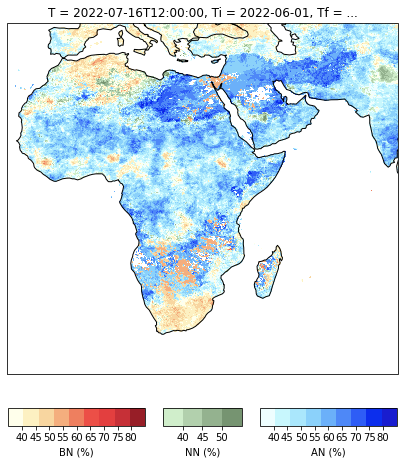

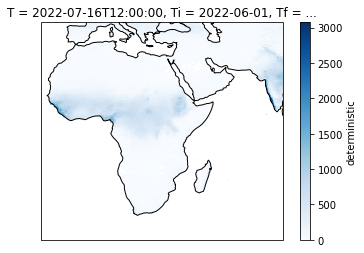

In [13]:
missing_value_flag = -999
prob_missing_value_flag = -1 

ce.view_probabilistic(pr_fcst.where(pr_fcst > prob_missing_value_flag).rename({'C':'M'}).isel(T=-1) / 100)
plt.show()
art = det_fcst.where(det_fcst > missing_value_flag).isel(T=-1).plot(subplot_kws={'projection': ccrs.PlateCarree()}, cmap='Blues', vmin=0)
art.axes.coastlines()
plt.show()

#### Flex Forecasts

In [20]:
threshold = 0.8 
isPercentile = True
point_latitude = -10
point_longitude = 16

## DO not modify below

# Define transformer based on transform_predictand setting
if MOS =='CCA':
    if str(cca_args['transform_predictand']).upper() == 'GAMMA':
        transformer = ce.GammaTransformer()
    elif str(cca_args['transform_predictand']).upper() == 'EMPIRICAL':
        transformer = ce.EmpiricalTransformer()
    else:
        transformer = None
elif MOS == 'PCR':
    if str(pcr_args['transform_predictand']).upper() == 'GAMMA':
        transformer = ce.GammaTransformer()
    elif str(pcr_args['transform_predictand']).upper() == 'EMPIRICAL':
        transformer = ce.EmpiricalTransformer()
    else:
        transformer = None
else:
    print('FLEX FORECASTS NOT POSSIBLE WITHOUT MOS')

In [21]:
from scipy.stats import norm, t

if MOS in ['CCA', 'PCR']:
    if transformer is not None: 
        transformer.fit(Y.expand_dims({'M':[0]}))
        fcst_mu = transformer.transform(det_fcst.expand_dims({'M':[0]}))
    else:
        fcst_mu = det_fcst

    if isPercentile:
        if transformer is None:
            threshold = Y.quantile(threshold, dim='T').drop('quantile')
        else:
            threshold = xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) * norm.cdf(threshold)
    else:
        if transformer is None:
            threshold = xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) * threshold 
        else: 
            threshold = xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) * threshold 
            threshold = transformer.transform(threshold)
    
    def _xr_tsf(thrs, loc1, scale1, dof1=1):
        return t.sf(thrs, dof1, loc=loc1, scale=scale1)
    
    ntrain = Y.shape[list(Y.dims).index('T')]
    fcst_scale = np.sqrt( (ntrain -2)/ntrain * pev_fcst )
    climo_var = xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) if transformer is not None else Y.var('T')
    climo_mu = xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) if transformer is not None else Y.mean('T')
    climo_scale = np.sqrt( (ntrain -2)/ntrain * climo_var )
    exceedance_prob = xr.apply_ufunc( _xr_tsf, threshold, fcst_mu, fcst_scale, input_core_dims=[['X', 'Y'], ['X', 'Y'], ['X', 'Y']], output_core_dims=[['X', 'Y']],keep_attrs=True, kwargs={'dof1':ntrain})

    
    
    
        
    
    

/Users/kylehall/anaconda3/envs/main/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/kylehall/anaconda3/envs/main/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/kylehall/anaconda3/envs/main/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2070: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/kylehall/anaconda3/envs/main/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2070: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


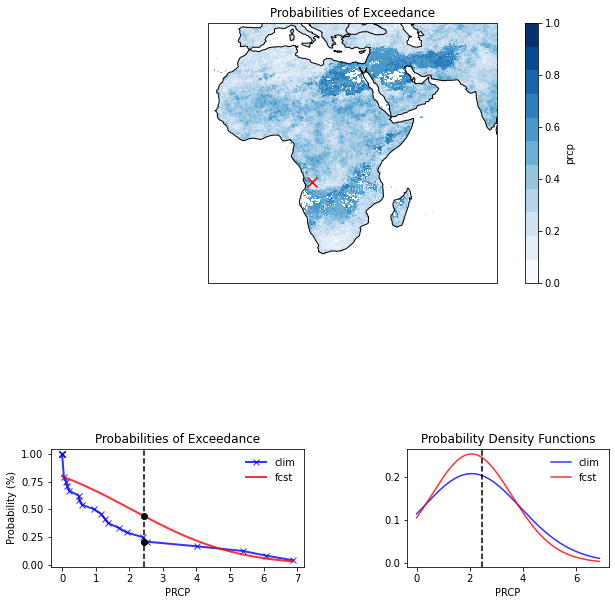

In [22]:
cmap=plt.get_cmap('Blues', 11)

fig = plt.figure(figsize=(10,10))
gs0 = gridspec.GridSpec(4, 1, figure=fig)
gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0:2])
gs11 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[3])
gs01 = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=gs11[0])
gs02 = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=gs11[1])

map_ax = fig.add_subplot(gs00[:,:], projection = ccrs.PlateCarree())
cdf_ax = fig.add_subplot(gs01[:,:5])     
pdf_ax = fig.add_subplot(gs02[:,1:])     

#plot the map
art = exceedance_prob.transpose('Y', 'X', ...).plot(cmap=cmap,  ax=map_ax, vmin=0, vmax=1) 
map_ax.scatter([point_longitude], [point_latitude], marker='x', s=100, color='red', transform=ccrs.PlateCarree())
coasts = art.axes.coastlines()

# point calculations 
point_threshold = float(threshold.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_fcst_scale = float(fcst_scale.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_climo_scale = float(climo_scale.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_fcst_mu = float(fcst_mu.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_climo_mu = float(climo_mu.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_climo = np.squeeze(Y.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_climo.sort()

x = point_climo 
x1 =np.linspace(x.min(), x.max(), 1000)
cprobth =  sum(x >= point_threshold) / x.shape[0]  #round(t.sf(point_threshold, ntrain, loc=point_climo_mu, scale=point_climo_scale),2)
fprobth = round(t.sf(point_threshold, ntrain, loc=point_fcst_mu, scale=point_fcst_scale),2)

cdf_ax.plot(x, [ sum(x >= x[i]) / x.shape[0] for i in range(x.shape[0]) ],'b-', lw=2, marker='x', alpha=0.8, label='clim')
cdf_ax.plot(x1, t.sf(x1, ntrain, loc=point_fcst_mu, scale=point_fcst_scale),'r-',  lw=2, alpha=0.8, label='fcst')


cdf_ax.plot(point_threshold, fprobth,'ok')
cdf_ax.plot(point_threshold, cprobth,'ok')
cdf_ax.axvline(x=point_threshold, color='k', linestyle='--')
cdf_ax.set_title('Probabilities of Exceedance')
cdf_ax.set_xlabel(Y.name.upper())
cdf_ax.set_ylabel('Probability (%)')
cdf_ax.legend(loc='best', frameon=False)

fpdf=t.pdf(x1, ntrain, loc=point_fcst_mu, scale=np.sqrt(point_fcst_scale))
pdf_ax.plot(x1, t.pdf(x1, ntrain, loc=point_fcst_mu, scale = np.sqrt((ntrain-2)/ntrain * x.var())), 'b-', alpha=0.8, label='clim')
pdf_ax.plot(x1, fpdf, 'r-',  alpha=0.8, label='fcst')

pdf_ax.axvline(x=point_threshold, color='k', linestyle='--')
pdf_ax.legend(loc='best', frameon=False)
pdf_ax.set_title('Probability Density Functions')
pdf_ax.set_xlabel(Y.name.upper())
pdf_ax.set_ylabel('')

title = map_ax.set_title('Probabilities of Exceedance')
